In [2]:
# imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Text Preprocessing
import nltk
# nltk.download("all")
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
# for the pictures
from wordcloud import WordCloud
import re
from sklearn.model_selection import cross_val_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv("/SMSSpamCollection", header = None, delimiter = '\t')

**Exploratory Data Analysis (EDA)**

---


In [4]:
df.columns = ['Label', 'Messages']

In [5]:
display(df.head())

,Label,Messages
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.isna().sum()

Label       0
Messages    0
dtype: int64

There is no missing values in the dataset

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Label     5572 non-null   object
 1   Messages  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


Both columns are Categorical

In [8]:
df.describe()

,Label,Messages
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


From freq row, it seems there are dupliated records in our dataset.

In [9]:
df[df.duplicated()]

,Label,Messages
103,ham,As per your request 'Melle Melle (Oru Minnamin...
154,ham,As per your request 'Melle Melle (Oru Minnamin...
207,ham,"As I entered my cabin my PA said, '' Happy B'd..."
223,ham,"Sorry, I'll call later"
326,ham,No calls..messages..missed calls
...,...,...
5524,spam,You are awarded a SiPix Digital Camera! call 0...
5535,ham,"I know you are thinkin malaria. But relax, chi..."
5539,ham,Just sleeping..and surfing
5553,ham,Hahaha..use your brain dear


In [10]:
df[df.duplicated()]['Label'].value_counts()

ham     309
spam     94
Name: Label, dtype: int64

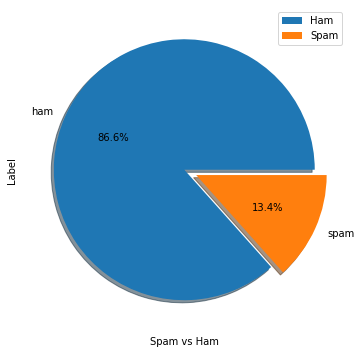

In [11]:
df["Label"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.xlabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

We can able to see that, there are 403 columns has a duplication, And out of 403 records, 309 are ham message records and 94 spam message records. This says that some messages are been repeated by the peoples often.In this type of problems duplicated messages are play a vital role for helping the model

It is an Imbalanced dataset, we can see the ratio of the class as 8:2 .So if we train our model with this dataset. There is an high probability that our model will be biased towards Ham message class, Because most of the records are from Ham Message class. We will first take care of the duplicates, and we can try to handle imbalanced dataset.

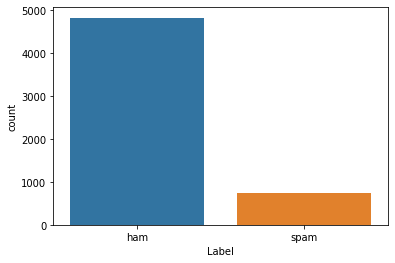

In [12]:
sns.countplot(x = df['Label'])

In [13]:
# looking for the most repeated words in both spam and ham message class.
df[df.duplicated()].value_counts()

Label  Messages                                                                                                                                                                           
ham    Sorry, I'll call later                                                                                                                                                                 29
       I cant pick the phone right now. Pls send a message                                                                                                                                    11
       Ok...                                                                                                                                                                                   9
       Ok                                                                                                                                                                                      3
       Wen ur lovable bcums angry wid u, 

In [14]:
repeated_messages = df.groupby("Messages")['Label'].value_counts().nlargest(20)

In [15]:
#The most repeated messages .
repeated_messages

Messages                                                                                                                                                                             Label
Sorry, I'll call later                                                                                                                                                               ham      30
I cant pick the phone right now. Pls send a message                                                                                                                                  ham      12
Ok...                                                                                                                                                                                ham      10
7 wonders in My WORLD 7th You 6th Ur style 5th Ur smile 4th Ur Personality 3rd Ur Nature 2nd Ur SMS and 1st "Ur Lovely Friendship"... good morning dear                              ham       4
Ok                                       

In [16]:
spam_messages = df[ df['Label'] == 'spam' ]
ham_messages = df[ df['Label'] == 'ham' ]
spam_words = [ ]
ham_words = [ ]

def spamword_extraction(message) :
  global spam_words
  words = [word.lower() for word in word_tokenize(message) if word.lower() not in stopwords.words('english') and word.lower().isalpha()]
  spam_words += words

def hamword_extraction(message) :
  global ham_words
  words = [word.lower() for word in word_tokenize(message) if word.lower() not in stopwords.words('english') and word.lower().isalpha()]
  ham_words += words

spam_messages.Messages.apply(spamword_extraction)
ham_messages.Messages.apply(hamword_extraction)



0       None
1       None
3       None
4       None
6       None
        ... 
5565    None
5568    None
5569    None
5570    None
5571    None
Name: Messages, Length: 4825, dtype: object

We are just trying to collect the spam words and ham words separately, so we applied word_tokenize to get the words from the sentences and stopwords to remove the stop words like repeated words which makes nosense for our project like it,the,i,etc..isaplha() method is useful to extract the words only has a alphabets in english.

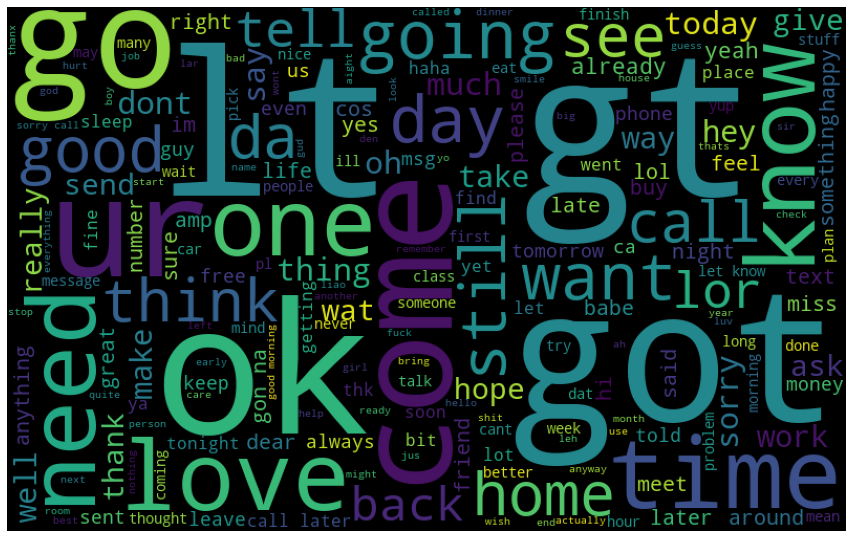

In [17]:
# Ham Words cloud.
ham_word_cloud = WordCloud(width=800, height=500).generate(" ".join(ham_words))
plt.figure(figsize = (12,10))
plt.imshow(ham_word_cloud)
plt.tight_layout(pad = 0)
plt.axis("off")
plt.show()

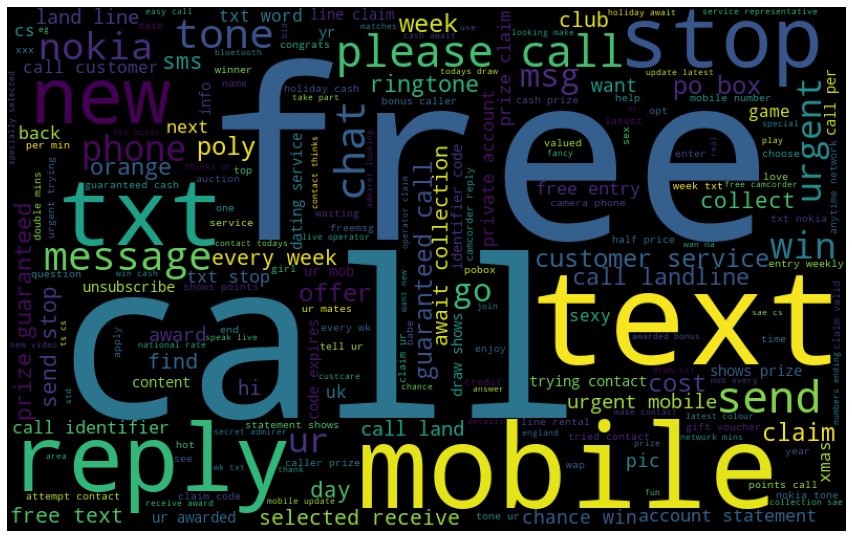

In [18]:
# Spam word cloud
spam_word_cloud = WordCloud(width=800, height=500).generate(" ".join(spam_words))
plt.figure(figsize = (12,10))
plt.imshow(spam_word_cloud)
plt.tight_layout(pad = 0)
plt.axis("off")
plt.show()

In [19]:
# Iam going to create a new dataset with handling the imbalanced data, i will try to compare the results between the imbalanced and 
# balanced dataset.
print(f"Number of Spam Message records {len(spam_messages)}")
print(f"Number of Ham Message records {len(ham_messages)}")


Number of Spam Message records 747
Number of Ham Message records 4825


In [20]:
# repeated words in both of the classes
# repeated words in the spam class 
from collections import Counter
repeated_spamwords = Counter(spam_words).most_common(25)
repeated_spamwords

[('call', 346),
 ('free', 217),
 ('txt', 156),
 ('u', 145),
 ('ur', 144),
 ('mobile', 123),
 ('text', 121),
 ('stop', 118),
 ('claim', 113),
 ('reply', 104),
 ('prize', 92),
 ('get', 84),
 ('send', 69),
 ('new', 69),
 ('nokia', 65),
 ('urgent', 63),
 ('cash', 62),
 ('win', 60),
 ('contact', 56),
 ('service', 55),
 ('week', 53),
 ('please', 53),
 ('c', 51),
 ('guaranteed', 50),
 ('customer', 49)]

In [21]:
# repeated words in ham class
repeated_hamwords = Counter(ham_words).most_common(25)
repeated_hamwords

[('u', 991),
 ('gt', 318),
 ('lt', 316),
 ('get', 302),
 ('go', 249),
 ('ok', 247),
 ('ur', 247),
 ('got', 245),
 ('know', 235),
 ('like', 233),
 ('call', 232),
 ('good', 229),
 ('come', 228),
 ('time', 195),
 ('love', 186),
 ('day', 182),
 ('ü', 172),
 ('going', 168),
 ('one', 168),
 ('want', 164),
 ('home', 158),
 ('lor', 156),
 ('need', 156),
 ('sorry', 155),
 ('still', 148)]

In [22]:
# message length before data preprocessing.
df['Messagelength_before'] = df['Messages'].apply(len)

In [23]:
# messages length before text preprocessing.
df

,Label,Messages,Messagelength_before
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,160
5568,ham,Will ü b going to esplanade fr home?,36
5569,ham,"Pity, * was in mood for that. So...any other s...",57
5570,ham,The guy did some bitching but I acted like i'd...,125


In [24]:
spam_message_len = df[df['Label'] == 'spam'].Messagelength_before

In [25]:
spam_message_len

2       155
5       147
8       157
9       154
11      136
       ... 
5537     90
5540    158
5547    160
5566    147
5567    160
Name: Messagelength_before, Length: 747, dtype: int64

In [26]:
ham_message_len = df[df['Label'] == 'ham'].Messagelength_before

In [27]:
ham_message_len

0       111
1        29
3        49
4        61
6        77
       ... 
5565     12
5568     36
5569     57
5570    125
5571     26
Name: Messagelength_before, Length: 4825, dtype: int64

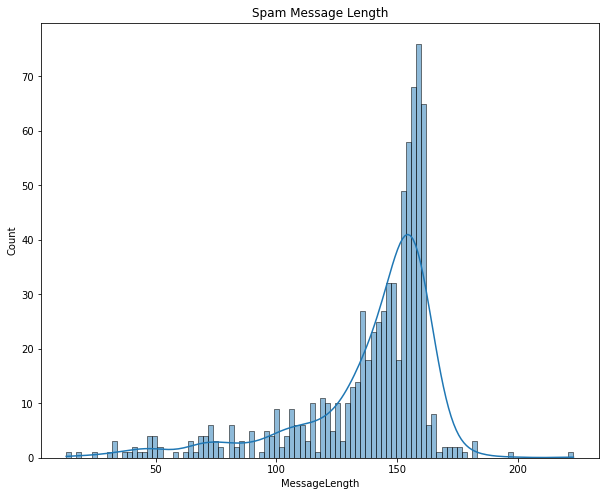

In [28]:
plt.figure(figsize = (10, 8))
sns.histplot(spam_message_len, kde = True, bins = 100)
plt.xlabel('MessageLength')
plt.title('Spam Message Length')
plt.show()

 Spam messages length are right skewed, which shows that the message, most of the messages length are higher.

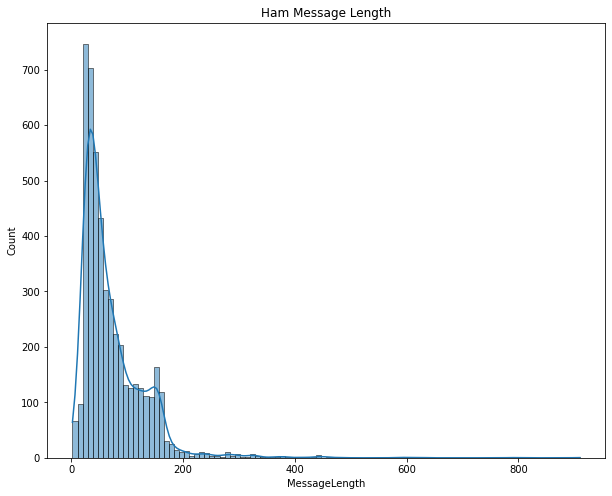

In [29]:
plt.figure(figsize = (10, 8))
sns.histplot(ham_message_len, kde = True, bins = 100)
plt.xlabel('MessageLength')
plt.title('Ham Message Length')
plt.show()

In [30]:
spam_message_len.describe()

count    747.000000
mean     138.670683
std       28.873603
min       13.000000
25%      133.000000
50%      149.000000
75%      157.000000
max      223.000000
Name: Messagelength_before, dtype: float64

In [31]:
ham_message_len.describe()

count    4825.000000
mean       71.482487
std        58.440652
min         2.000000
25%        33.000000
50%        52.000000
75%        93.000000
max       910.000000
Name: Messagelength_before, dtype: float64

From both Spam and Ham messages, we can notice that 25 % of messages length in ham messages are 33 and 75 % are 93 length which is lesser than the 25 % of the spam message length, So we can observe that the spam message length is most of the time higher than the ham message length.

**Feature Engineering**

---



---



In [32]:
# text preprocessing
def text_preprocessing(message) :
  # removing a numbers from the message
  pattern = r'[0-9]'
  message = re.sub(pattern, ' ', message)

  # removing special character and punctuations and every other things from the message.
  message = re.sub('[^A-Za-z0-9]+', ' ', message)

  #applying a stop word 
  message = [word for word in word_tokenize(message)]
  words = [word.lower() for word in message if not word in stopwords.words('english')]
  message = ' '.join(words)

  return message
  

In [33]:
df['NewMessage'] = df['Messages'].apply(text_preprocessing)

In [34]:
df['NewMessageLen'] = df['NewMessage'].apply(len)

In [35]:
df.head()

,Label,Messages,Messagelength_before,NewMessage,NewMessageLen
0,ham,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazy available bugis n great ...,82
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni,23
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp win fa cup final tkts st ...,103
3,ham,U dun say so early hor... U c already then say...,49,u dun say early hor u c already say,35
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah i think goes usf lives around though,40


After doing a text preprocessing length of the messages of both spam and ham classes are decreased, So now also we will check whether the distribution of the messages length of both classes still same like before doing the text preprocessing.

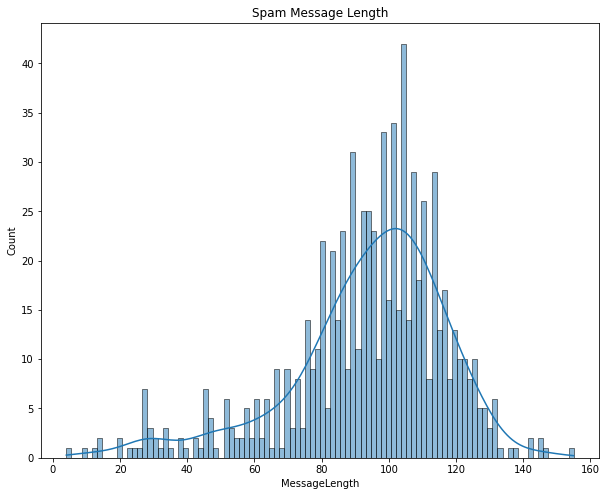

In [36]:
spam_message_len_after = df[df['Label'] == 'spam'].NewMessageLen
plt.figure(figsize = (10, 8))
sns.histplot(spam_message_len_after, kde = True, bins = 100)
plt.xlabel('MessageLength')
plt.title('Spam Message Length')
plt.show()

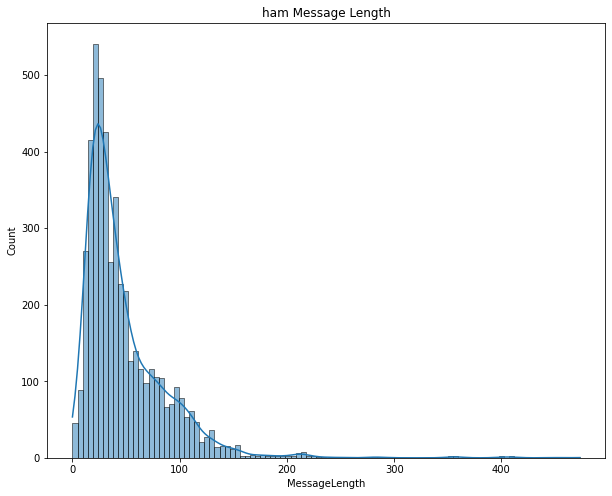

In [37]:
ham_message_len_after = df[df['Label'] == 'ham'].NewMessageLen
plt.figure(figsize = (10, 8))
sns.histplot(ham_message_len_after, kde = True, bins = 100)
plt.xlabel('MessageLength')
plt.title('ham Message Length')
plt.show()

In [38]:
spam_message_len_after.describe()

count    747.000000
mean      93.986613
std       23.356368
min        4.000000
25%       84.000000
50%       98.000000
75%      109.000000
max      155.000000
Name: NewMessageLen, dtype: float64

In [39]:
ham_message_len_after.describe()

count    4825.000000
mean       47.990052
std        39.823219
min         0.000000
25%        22.000000
50%        35.000000
75%        63.000000
max       473.000000
Name: NewMessageLen, dtype: float64

So still after the text preprocessing ham messages length 75 % is still lesser than the 25 % of the spam messages.

In [40]:
# converting the text into words and words into the vectors, bcoz machine learning and deep learning model only understand the numerical values

In [41]:
df.head()

,Label,Messages,Messagelength_before,NewMessage,NewMessageLen
0,ham,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazy available bugis n great ...,82
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni,23
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp win fa cup final tkts st ...,103
3,ham,U dun say so early hor... U c already then say...,49,u dun say early hor u c already say,35
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah i think goes usf lives around though,40


In [42]:
df.drop('Messages', axis = 1, inplace = True)
df['Messages'] = df['NewMessage']
df.drop('NewMessage', inplace = True, axis = 1)

In [43]:
df.head(1)

,Label,Messagelength_before,NewMessageLen,Messages
0,ham,111,82,go jurong point crazy available bugis n great ...


In [44]:
y = df['Label']

In [45]:
y = np.where(y == 'ham', 0, 1)

In [46]:
y

array([0, 0, 1, ..., 0, 0, 0])

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
countvectorizer = CountVectorizer(max_features = 5000)
X = countvectorizer.fit_transform(df['Messages']) .toarray()

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y)

In [48]:
# these are the features used in the bag of words
#countvectorizer.get_feature_names()

#**Model selection with Imbalanced Dataset** 

---



# Performance of the models is calculated using the F1-Score.
1. Multinomial Naive Bayes ---> 0.938
2. Random Forest Classifier ---> 0.909
3. Support Vector Machine Classifier ---> 0.914

In [49]:
from sklearn.naive_bayes import MultinomialNB

In [50]:
# MultiNomial Naive Bayes
multinb = MultinomialNB()
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

-----Confusion Matrix for MultiNomial Naive Bayes with imbalanced dataset----


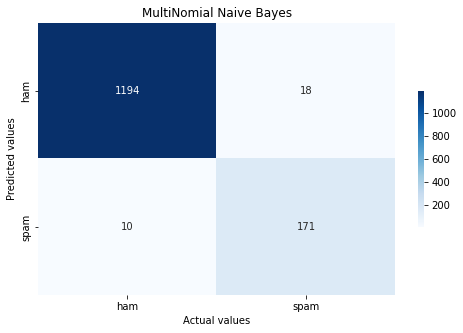



-----classification report-------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1212
           1       0.90      0.94      0.92       181

    accuracy                           0.98      1393
   macro avg       0.95      0.96      0.96      1393
weighted avg       0.98      0.98      0.98      1393


Scores for Multinomial Model with imbalanced data is [0.93103448 0.95412844 0.92857143 0.93913043 0.91666667 0.97345133
 0.88695652 0.93220339 0.9380531  0.97391304]

Average score for the Multinomial with imbalanced data is 0.9374108832972958


In [51]:
cross_val_scores = cross_val_score(multinb, x_train, y_train, cv = 10, scoring = 'f1')

multinb.fit(x_train, y_train)
y_pred = multinb.predict(x_test)


print("-----Confusion Matrix for MultiNomial Naive Bayes with imbalanced dataset----")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,5))
axis_labels = ['ham', 'spam']
ga = sns.heatmap(data=cm, annot=True, cmap="Blues", xticklabels=axis_labels, yticklabels=axis_labels, fmt='g', cbar_kws={"shrink": 0.5})
plot = plt.xlabel('Actual values')
plot = plt.ylabel('Predicted values')
plot = plt.title('MultiNomial Naive Bayes')
plt.show()
print()
print()

print("-----classification report-------")
print(classification_report(y_test, y_pred))
print()


print(f"Scores for Multinomial Model with imbalanced data is {cross_val_scores}")
print()

print(f"Average score for the Multinomial with imbalanced data is {cross_val_scores.mean()}")


-----Confusion Matrix for Random Forest with imbalanced dataset----


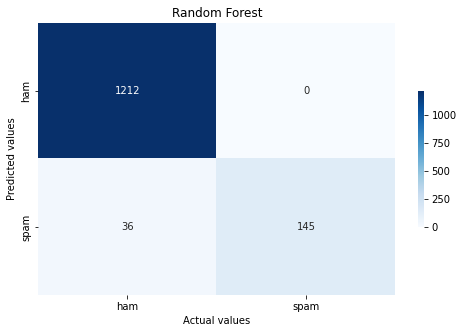



-----classification report-------
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1212
           1       1.00      0.80      0.89       181

    accuracy                           0.97      1393
   macro avg       0.99      0.90      0.94      1393
weighted avg       0.97      0.97      0.97      1393


Scores for Random Forest with imbalanced data is [0.93333333 0.92307692 0.88       0.90384615 0.9245283  0.93577982
 0.87378641 0.9245283  0.84848485 0.91262136]

Average score for the Random Forest with imbalanced data is 0.9059985446018896


In [52]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier()

cross_val_scores = cross_val_score(randomforest, x_train, y_train, cv = 10, scoring = 'f1')

randomforest.fit(x_train, y_train)
y_pred_randomforest = randomforest.predict(x_test)



# confusion matrix
print("-----Confusion Matrix for Random Forest with imbalanced dataset----")
cm = confusion_matrix(y_test, y_pred_randomforest)
plt.figure(figsize=(8,5))
axis_labels = ['ham', 'spam']
ga = sns.heatmap(data=cm, annot=True, cmap="Blues", xticklabels=axis_labels, yticklabels=axis_labels, fmt='g', cbar_kws={"shrink": 0.5})
plot = plt.xlabel('Actual values')
plot = plt.ylabel('Predicted values')
plot = plt.title('Random Forest')
plt.show()
print()
print()


print("-----classification report-------")
print(classification_report(y_test, y_pred_randomforest))
print()


print(f"Scores for Random Forest with imbalanced data is {cross_val_scores}")
print()

print(f"Average score for the Random Forest with imbalanced data is {cross_val_scores.mean()}")



-----Confusion Matrix for Support Vector Machine with imbalanced dataset----


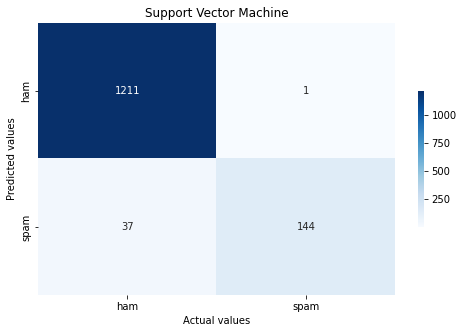


-----classification report-------
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1212
           1       0.99      0.80      0.88       181

    accuracy                           0.97      1393
   macro avg       0.98      0.90      0.93      1393
weighted avg       0.97      0.97      0.97      1393


Scores for Svm Model with imbalanced data is [0.90384615 0.90196078 0.85714286 0.95412844 0.94444444 0.94444444
 0.90384615 0.90384615 0.88235294 0.92307692]

Average score for the Svm with imbalanced data is 0.9119089296504299


In [53]:
# SVM
from sklearn.svm import SVC
supportv_classifier = SVC()

cross_val_scores = cross_val_score(supportv_classifier, x_train, y_train, cv = 10, scoring = 'f1')


supportv_classifier.fit(x_train, y_train)
y_pred_svm = supportv_classifier.predict(x_test)


# confusion matrix
print("-----Confusion Matrix for Support Vector Machine with imbalanced dataset----")
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8,5))
axis_labels = ['ham', 'spam']
ga = sns.heatmap(data=cm, annot=True, cmap="Blues", xticklabels=axis_labels, yticklabels=axis_labels, fmt='g', cbar_kws={"shrink": 0.5})
plot = plt.xlabel('Actual values')
plot = plt.ylabel('Predicted values')
plot = plt.title('Support Vector Machine')
plt.show()
print()


print("-----classification report-------")
print(classification_report(y_test, y_pred_svm))
print()



print(f"Scores for Svm Model with imbalanced data is {cross_val_scores}")
print()

print(f"Average score for the Svm with imbalanced data is {cross_val_scores.mean()}")

#**Model selection with balanced dataset**

---



---



Trying to balance a imbalanced dataset in this kind of problem and seeing whether it works for this kind of problem or not. Balancing a dataset using a Upsmapling method.

# Performance of the Model is calculated using the Acurracy
1. Multinomial Naive Bayes ---->   0.983
2. Random Forest Classifier ---->   1.000
3. Support Vector Machine Classifier ---->  0.997

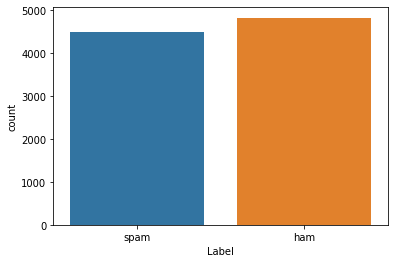



-----Confusion Matrix for MultiNomial Naive Bayes with balanced data------


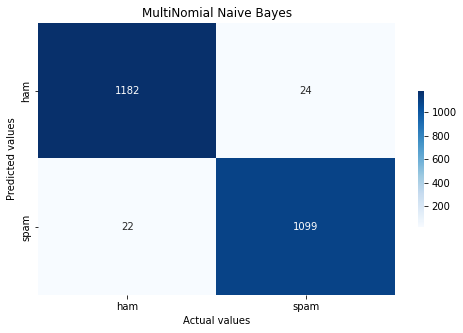


-------classification report of the Model------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1206
           1       0.98      0.98      0.98      1121

    accuracy                           0.98      2327
   macro avg       0.98      0.98      0.98      2327
weighted avg       0.98      0.98      0.98      2327


-----Result of MultiNomial Naive Bayes------
[0.98280802 0.98424069 0.98567335 0.97994269 0.97851003 0.9756447
 0.98997135 0.98280802 0.98137536 0.97851003] scores of the cross validation

0.982 is the average score from cross validation


In [54]:
from sklearn.preprocessing import LabelEncoder

spam_messages_df = pd.DataFrame(spam_messages)
for _ in range(5) : 
  samples = spam_messages.sample(n = 747)
  spam_messages_df = pd.concat([spam_messages_df, samples], axis = 0)
new_df = pd.concat([spam_messages_df, ham_messages])

sns.countplot(x = new_df['Label'])
plt.show()


new_df['NewMessage'] = new_df['Messages'].apply(text_preprocessing)
new_df['NewMessageLen'] = new_df['NewMessage'].apply(len)
new_df.drop('Messages', axis = 1, inplace = True)
new_df['Label'] = new_df['Label'].map({'ham': 0, 'spam': 1})

X1 = new_df['NewMessage']
y1 = new_df['Label']


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
countvectorizer = CountVectorizer(max_features = 5000)
X1 = countvectorizer.fit_transform(new_df['NewMessage']) .toarray()
x1_train, x1_test,y1_train, y1_test = train_test_split(X1, y1, random_state = 0)

# MultiNomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
multinb1 = MultinomialNB()

print()
print()


scores = cross_val_score(multinb1, x1_train, y1_train, cv = 10)

multinb1.fit(x1_train, y1_train)
y1_pred = multinb1.predict(x1_test)



print("-----Confusion Matrix for MultiNomial Naive Bayes with balanced data------")
cm = confusion_matrix(y1_test, y1_pred)
plt.figure(figsize=(8,5))
axis_labels = ['ham', 'spam']
ga = sns.heatmap(data=cm, annot=True, cmap="Blues", xticklabels=axis_labels, yticklabels=axis_labels, fmt='g', cbar_kws={"shrink": 0.5})
plot = plt.xlabel('Actual values')
plot = plt.ylabel('Predicted values')
plot = plt.title('MultiNomial Naive Bayes')
plt.show()
print()




print("-------classification report of the Model------")
print(classification_report(y1_test, y1_pred))
print()



print("-----Result of MultiNomial Naive Bayes------")

print(f"{scores} scores of the cross validation")
print()
print(f"{np.round(scores.mean(), 3)} is the average score from cross validation")

After balancing the dataset, the result is quite good.

-----Confusion Matrix for Random Forest with balanced dataset----


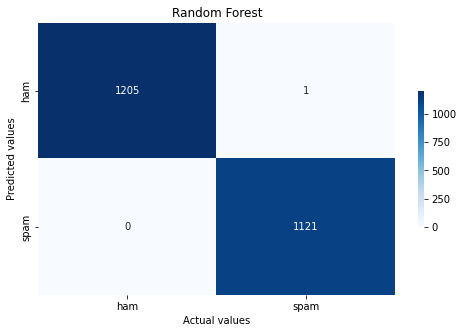



-----classification report-------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1206
           1       1.00      1.00      1.00      1121

    accuracy                           1.00      2327
   macro avg       1.00      1.00      1.00      2327
weighted avg       1.00      1.00      1.00      2327


Scores for Random Forest with balanced data is [1.         1.         1.         1.         0.99856734 1.
 1.         0.99856734 1.         1.        ]

Average score for the Random Forest with balanced data is 0.9997134670487107


In [60]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier()

cross_val_scores = cross_val_score(randomforest, x1_train, y1_train, cv = 10, scoring = 'accuracy')

randomforest.fit(x1_train, y1_train)
y1_pred_randomforest = randomforest.predict(x1_test)


# confusion matrix
print("-----Confusion Matrix for Random Forest with balanced dataset----")
cm = confusion_matrix(y1_test, y1_pred_randomforest)
plt.figure(figsize=(8,5))
axis_labels = ['ham', 'spam']
ga = sns.heatmap(data=cm, annot=True, cmap="Blues", xticklabels=axis_labels, yticklabels=axis_labels, fmt='g', cbar_kws={"shrink": 0.5})
plot = plt.xlabel('Actual values')
plot = plt.ylabel('Predicted values')
plot = plt.title('Random Forest')
plt.show()
print()
print()



print("-----classification report-------")
print(classification_report(y1_test, y1_pred_randomforest))
print()

from sklearn.model_selection import cross_val_score

print(f"Scores for Random Forest with balanced data is {cross_val_scores}")
print()

print(f"Average score for the Random Forest with balanced data is {cross_val_scores.mean()}")


-----Confusion Matrix for Support Vector Machine with balanced dataset----


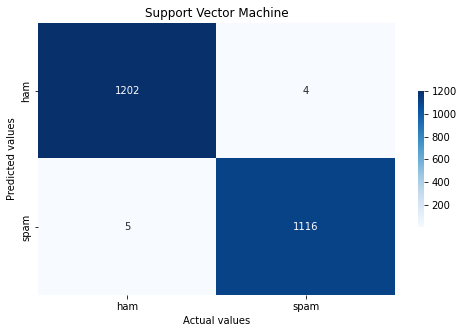


-----classification report-------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1206
           1       1.00      1.00      1.00      1121

    accuracy                           1.00      2327
   macro avg       1.00      1.00      1.00      2327
weighted avg       1.00      1.00      1.00      2327


Scores for Svm Model with balanced data is [0.98395415 0.99025788]

Average score for the Svm with balanced data is 0.987106017191977


In [61]:
# SVM
from sklearn.svm import SVC
supportv_classifier = SVC()

cross_val_scores = cross_val_score(supportv_classifier, x1_train, y1_train, cv = 2, scoring = 'accuracy')

supportv_classifier.fit(x1_train, y1_train)
y1_pred_svm = supportv_classifier.predict(x1_test)

# confusion matrix
print("-----Confusion Matrix for Support Vector Machine with balanced dataset----")
cm = confusion_matrix(y1_test, y1_pred_svm)
plt.figure(figsize=(8,5))
axis_labels = ['ham', 'spam']
ga = sns.heatmap(data=cm, annot=True, cmap="Blues", xticklabels=axis_labels, yticklabels=axis_labels, fmt='g', cbar_kws={"shrink": 0.5})
plot = plt.xlabel('Actual values')
plot = plt.ylabel('Predicted values')
plot = plt.title('Support Vector Machine')
plt.show()
print()


print("-----classification report-------")
print(classification_report(y1_test, y1_pred_svm))
print()


print(f"Scores for Svm Model with balanced data is {cross_val_scores}")
print()

print(f"Average score for the Svm with balanced data is {cross_val_scores.mean()}")

Using the Random Forest Model

In [62]:
# prediction
def _prediction(message) :
  message = text_preprocessing(message)
  test_data = countvectorizer.transform([message]).toarray()
  prediction = randomforest.predict(test_data)
  return "Message is Spam!!!" if prediction ==1 else "Message is not Spam!!!!!"

Test Predictions

In [63]:
_prediction("Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's")

'Message is Spam!!!'

In [64]:
_prediction("U dun say so early hor... U c already then say...")

'Message is not Spam!!!!!'